In [21]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [22]:
# id,frame,x [nm],y [nm],sigma [nm],intensity [photon],amplitude [photon],offset [photon],bkgstd [photon],uncertainty_xy [nm]
id, frame, x, y, sigma, intensity, amplitude, offset, bkgstd, uncertainty_xy = np.loadtxt("../data/microtubules/Acquisition-5/CoordTable_SAFE180_2D.csv",
                                                                                          unpack=True, delimiter=',', skiprows=1)

Interesting: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density

Ou sinon on utilise le TIFF

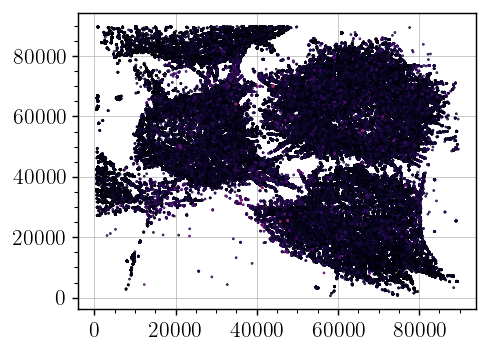

In [27]:
plt.scatter(x,y, marker='.', s=1,
            c=intensity, cmap='inferno')
plt.show()

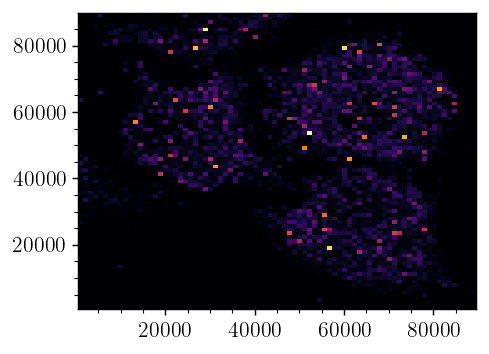

In [24]:
plt.hist2d(x,y, bins=80, cmap='inferno')
plt.show()

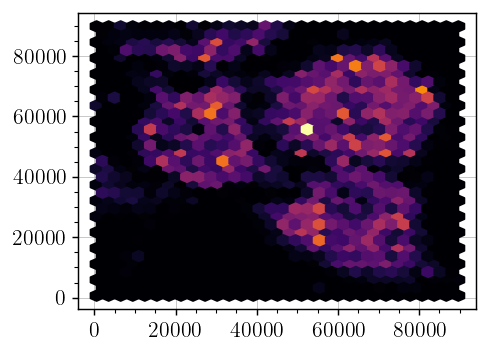

In [25]:
plt.hexbin(x,y, gridsize=30, cmap='inferno')
plt.show()